In [49]:
from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import kwant
from wraparound import wraparound
print(kwant.__version__)

plt.rcParams['text.usetex'] = True

1.3.3


In [13]:
# Helper functions
def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(graphene.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)


def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200, _figsize=(8,8), dpi=196):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
    momenta = np.linspace(-lim, lim, num_points)
    energies = []
    for kx in momenta:
        for ky in momenta:
            lattice_k = momentum_to_lattice([kx, ky])
            h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
            energies.append(np.linalg.eigvalsh(h))
    
    energies = np.array(energies).reshape(num_points, num_points, -1)
    emin, emax = np.min(energies), np.max(energies)
    kx, ky = np.meshgrid(momenta, momenta)
    fig = plt.figure(figsize=_figsize, dpi=dpi)
    axes = fig.add_subplot(1, 1, 1, projection='3d')
    axes.view_init(15, 60)
    for band in range(energies.shape[-1]):
        axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                          cmap='Spectral', vmin=emin, vmax=emax,
                          linewidth=0.1)
    return fig

In [14]:
graphene = kwant.lattice.general([[1, 0], [1/2, np.sqrt(3)/2]],  # lattice vectors
                                 [[0, 0], [0, 1/np.sqrt(3)]])   # Coordinates of the sites
a, b = graphene.sublattices

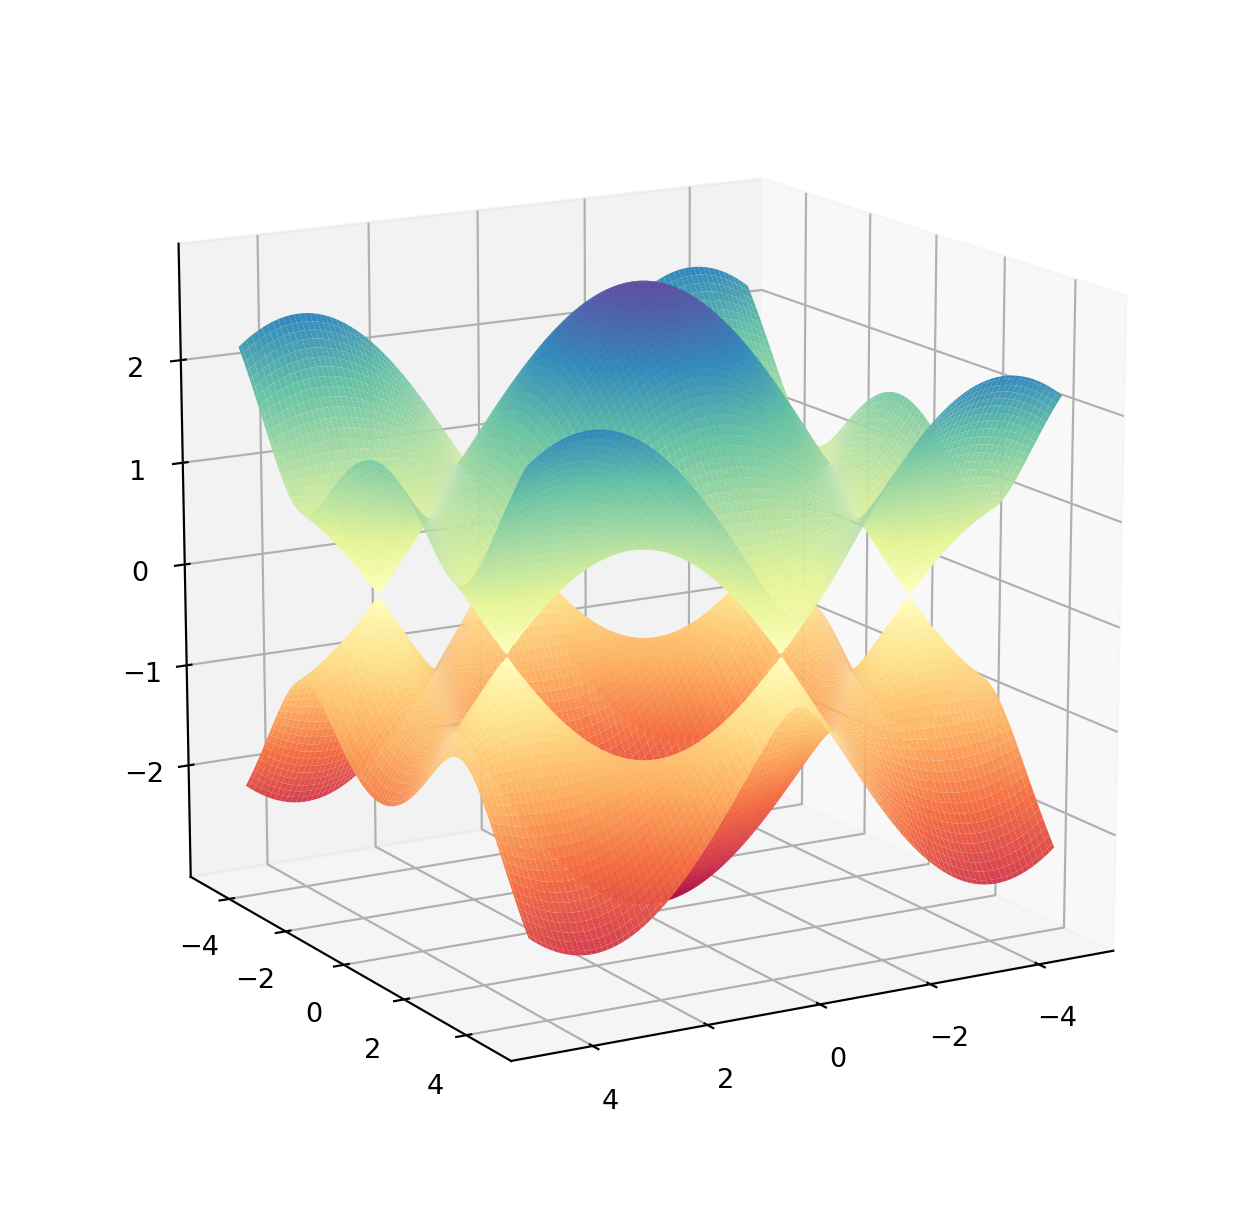

In [15]:
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_graphene[graphene.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[graphene.neighbors(1)] = 1

fig = dispersion_2D(wraparound(bulk_graphene).finalized())

In [16]:
fig.savefig("Bulk_graphene_bandstructre_3d.png", dpi=196)

# Haldane model of anomalous quantum Hall effect
### WTF is anomalous quantum Hall effect???

In [17]:
nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b

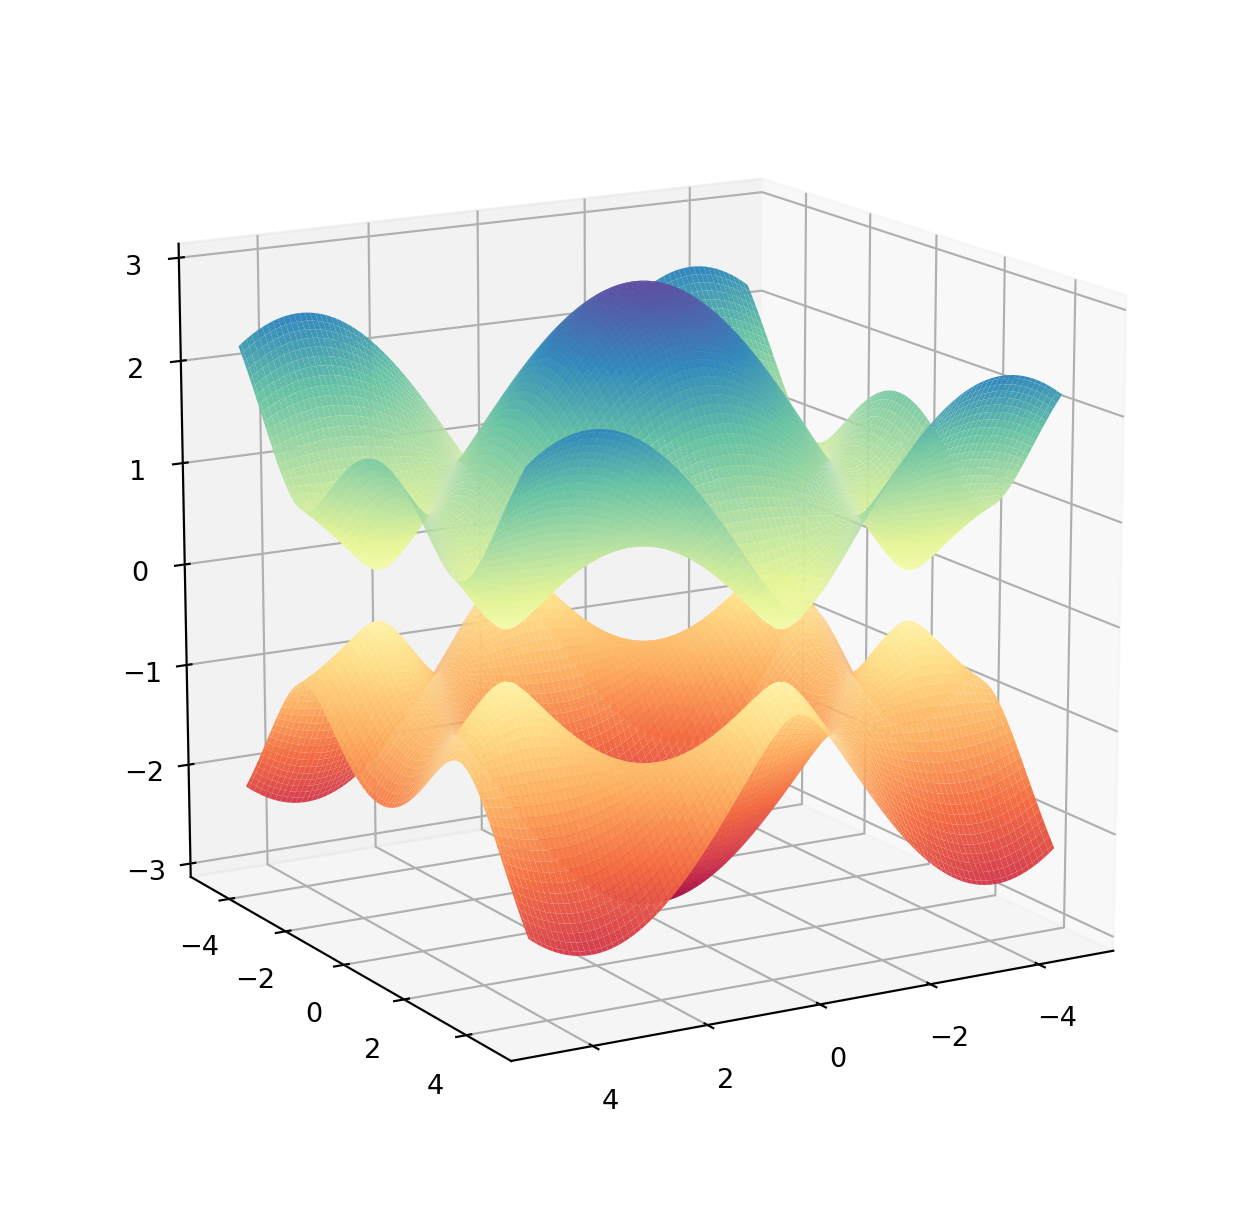

In [26]:
def nnn_hopping(site1, site2, params):
    return 1j * params.t_2

def onsite(site, params):
    return params.m * (1 if site.family == a else -1)

def add_hoppings(syst):
    syst[graphene.neighbors(1)] = 1
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = nnn_hopping

haldane = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
haldane[graphene.shape((lambda pos: True), (0, 0))] = onsite
haldane[graphene.neighbors(1)] = 1
haldane[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = nnn_hopping

t_2 = 0
m  = .25
fig = dispersion_2D(wraparound(haldane).finalized(), [SimpleNamespace(t_2=t_2, m=m)], num_points=200)

In [27]:
fig.savefig("haldane_bandstruct_t2={0}_m={1}.png".format('dot'.join(str(t_2).split('.')),
                                                         'dot'.join(str(m).split('.'))))

## Quantum spin Hall effect in Kane-Mele model

(Following: C.L. Kane and E.J. Mele, Phys. Rev. Lett. **95**, 226801 (2005))
[arxiv article](https://arxiv.org/pdf/cond-mat/0506581.pdf)
[arxiv article 2](https://arxiv.org/pdf/cond-mat/0411737.pdf)
Haldane model breaks time-reversal symmetry and inversion symmetry. Lattice-scale hoppings that break time-reversal symmetry do not appear in non-magnetic materials. We can make the Hamiltonian invariant under inversion and time-reversal by making the next-nearest neighbor hoppings spin-dependent.

So if we take those hoppings equal to $i t_2 \sigma_z$, we get teh

In [28]:
# Pauli matrices 
s0 = np.identity(2)
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.diag([1, -1])

In [29]:
def spin_orbit(site1, site2, params):
    return 1j * params.t_2 * sz

def onsite(site, params):
    return s0 * params.m * (1 if site.family == a else -1)

def add_hoppings(syst):
    syst[graphene.neighbors(1)] = s0
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = spin_orbit

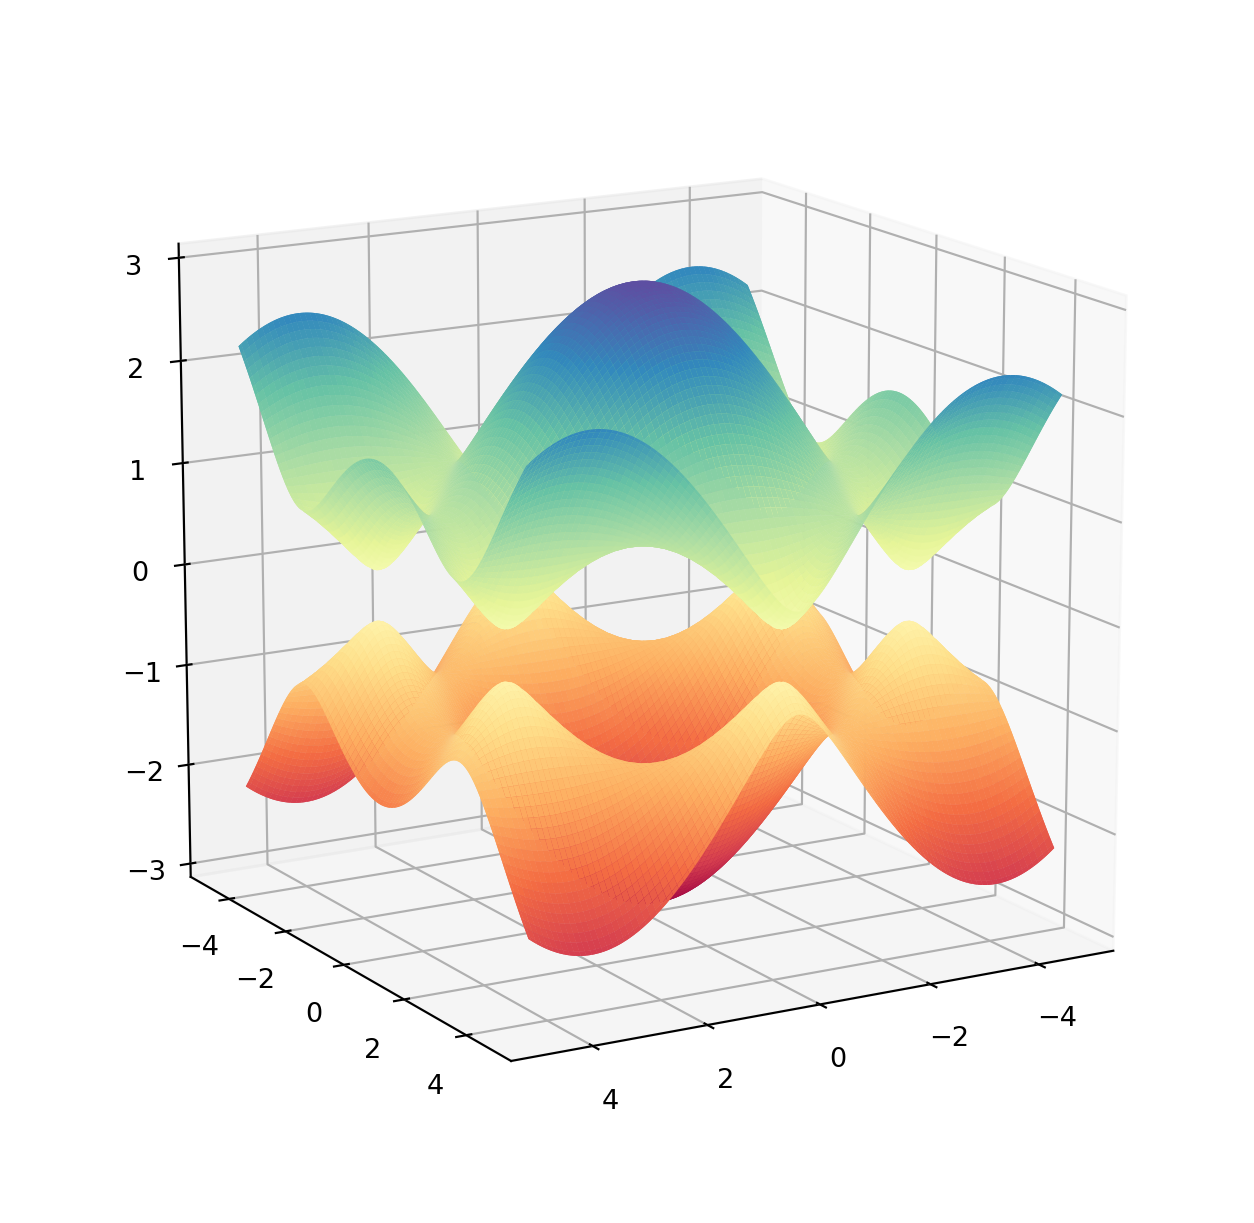

In [30]:
bulk_kane_mele = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_kane_mele[graphene.shape((lambda pos: True), (0, 0))] = onsite
add_hoppings(bulk_kane_mele)

t_2 = 0
m = 0.25
fig = dispersion_2D(wraparound(bulk_kane_mele).finalized(), [SimpleNamespace(t_2=t_2, m=m)], num_points=200)

In [31]:
fig.savefig("kane-mele-t_2={0}_m={1}.png".format('dot'.join(str(t_2).split('.')),
                                                 'dot'.join(str(m).split('.'))), dpi=196)

# Graphene transmission coefficient with Kane-Mele Hamiltonian

In [184]:
def create_graphene(W, L, V_onsite=0, use_kane_mele=False, t_2=0, m=0.25):
  # Lattice
  lat = kwant.lattice.general([(np.sqrt(3)*1/2, 1/2), (0, 1)],
                              [(0, 0), (1/(2*np.sqrt(3)),1/2)],
                              norbs = 1)
  
  # Pauli matrices 
  s0 = np.identity(2)
  sx = np.array([[0, 1], [1, 0]])
  sy = np.array([[0, -1j], [1j, 0]])
  sz = np.diag([1, -1])
  
  def scattering_region(pos):
    x, y = pos
    return abs(x) < L/2 and abs(y) < W/2
  
  def lead_shape(pos):
    x, y = pos
    return abs(y) < W/2
  
  def onsite(site, params):
      return np.random.uniform(-params.disorder, params.disorder)
  
  def hopping(sitei, sitej, params):
    xi, yi = sitei.pos
    xj, yj = sitej.pos
    t = params.t*np.exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
    if use_kane_mele == False:
      return t
    else:
      return t + t_2*sz
    
  sys = kwant.Builder()
  
  sys[lat.shape(scattering_region, (0,0))] = onsite
  sys[lat.neighbors()] = hopping
  
  # Attaching leads
  sym = kwant.TranslationalSymmetry(lat.vec((-2,1)))
  
  L_0 = kwant.Builder(sym)
  L_0[lat.shape(lead_shape, (0,0))] = onsite
  L_0[lat.neighbors()] = hopping
  L_1 = L_0.reversed()
  
  sys.attach_lead(L_0)
  sys.attach_lead(L_1)
  
  return sys

def create_graphene_kane_mele(W, L):
  # Pauli matrices 
  s0 = np.identity(2)
  sx = np.array([[0, 1], [1, 0]])
  sy = np.array([[0, -1j], [1j, 0]])
  sz = np.diag([1, -1])
  
  graphene = kwant.lattice.general([[1, 0], [1/2, np.sqrt(3)/2]],  # lattice vectors
                                   [[0, 0], [0, 1/np.sqrt(3)]])   # Coordinates of the sites
  a, b = graphene.sublattices
  
  nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
  nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
  nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b
  
  def spin_orbit(site1, site2, params):
    return 1j * params.t_2 * sz

  def onsite(site, params):
      return s0 * params.m * (1 if site.family == a else -1)

  def add_hoppings(syst):
      syst[graphene.neighbors(1)] = s0
      syst[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = spin_orbit
  
  def scattering_region(pos):
    x, y = pos
    return abs(x) < L/2 and abs(y) < W/2
  
  sys = kwant.Builder() # kwant.TranslationalSymmetry(*graphene.prim_vecs)
  sys[graphene.shape(scattering_region, (0, 0))] = onsite
  add_hoppings(sys)
  
  def add_leads(syst):
    def lead_shape(pos):
      x, y = pos
      return abs(y) < W/4 and abs(x) < 6
    
    sym = kwant.TranslationalSymmetry([1,0])
    L_0 = kwant.Builder(sym)
    L_0[graphene.shape(lead_shape, (0,0))] = onsite
    add_hoppings(L_0)
    L_1 = L_0.reversed()
    
    syst.attach_lead(L_0)
    syst.attach_lead(L_1)
    return
  
  add_leads(sys)
  return sys

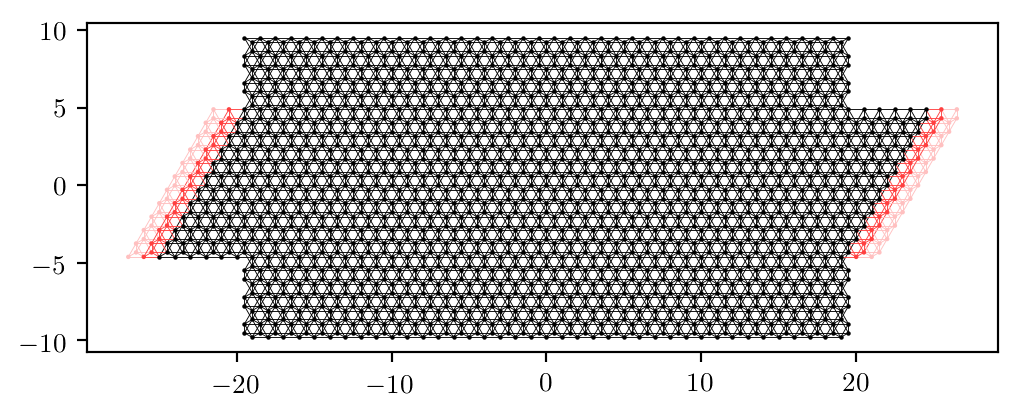

In [185]:
sys_km = create_graphene_kane_mele(20, 40)
fig = kwant.plot(sys_km, dpi=196);
fig.savefig("graphene_KM_lattice_W=20_L=40.png", dpi=196)

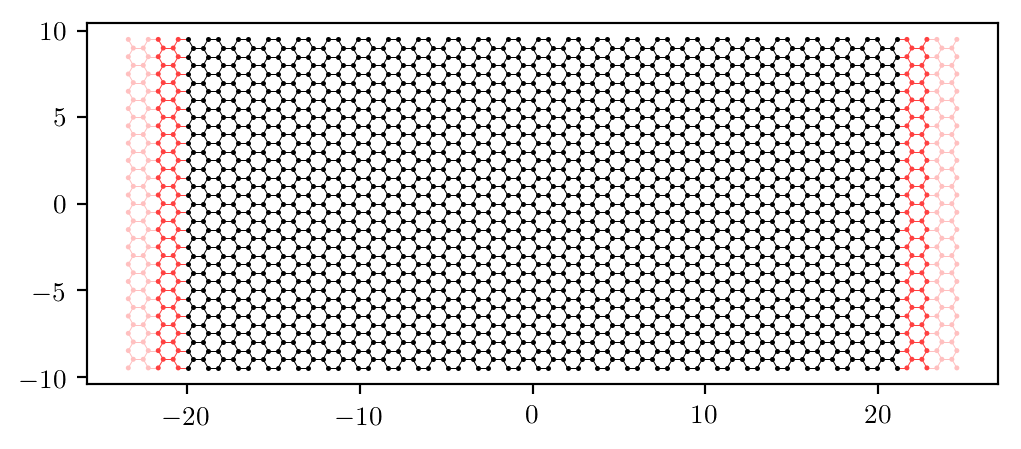

In [171]:
sys = create_graphene(20, 40)
fig = kwant.plot(sys, dpi=196);
fig.savefig("graphene_lattice_W=20_L=40.png", dpi=196)

In [192]:
Gs = {}

phi = 0.2

np.random.seed(0)
W0s = np.linspace(0, 5, 40) #np.logspace(0, np.log(5000)/np.log(10), 50)
energies = np.linspace(0, 0.6, 4)

fsyst = sys.finalized()
for e in energies:
  Gs[repr(e)] = []
  for W0 in W0s:
      params = SimpleNamespace(disorder=W0, t=-1, phi=phi)
      smat = kwant.smatrix(fsyst, energy=energy, args=[params])
      Gs[repr(e)].append(smat.transmission(1, 0))

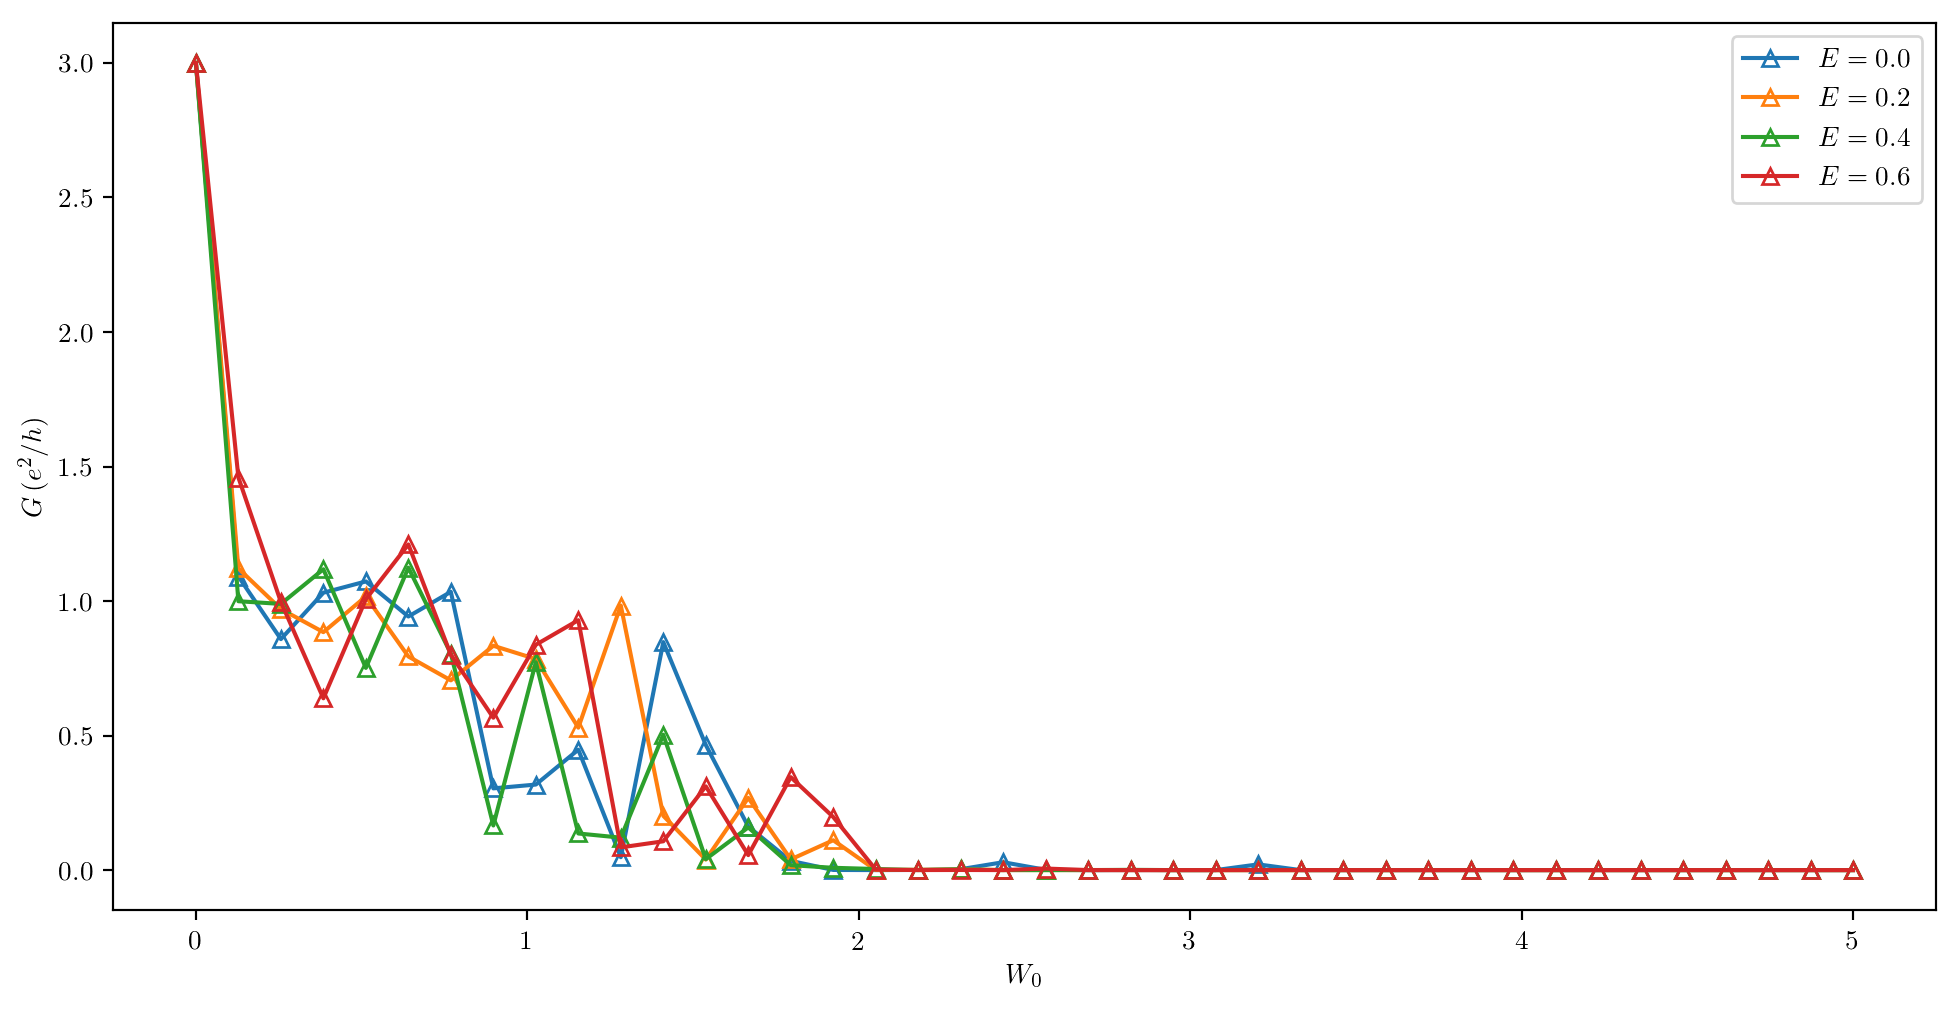

In [193]:
plt.figure(figsize=(12,6), dpi=196)
for e in energies:
  plt.plot(W0s, Gs[repr(e)], '^-', mfc='none', label="$E={}$".format(np.round(e, 2)));
#plt.xscale('log')
plt.ylabel("$G\,(e^2/h)$")
plt.xlabel("$W_0$")
plt.legend()
plt.savefig("transmission_graphene_lat_phi={0}Wmax={1}".format("dot".join(str(phi).split('.')), 5))

# Applying disorder
Disorder enters the Hamiltonian as a disorder potential $V_\text{dis}$. There are various models for such potentials. A very commonly used model is to add a random on-site potential to the tight-binding model:

$$V_\text{dis} = \sum_i W_i |\mathbf{x}_i\rangle \langle \mathbf{x}_i|$$

where the $W_i$ are choosen randomly from a uniform distribution $[-W_0/2, W_0/2]$.

It is worth noting that the disorder strength $W_0$ by itself does not mean much. Instead
one must quantify the disorder strength by a physical quantitiy. For disorder this is the 
mean free path. From Fermi's golden rule one can compute that for this model

$$l_\text{mfp} = 48 a\, \frac{\sqrt{E/t}}{(W_0/t)^2}$$

where $a$ is again the lattice constant, $t$ the hopping energy on the square lattice.

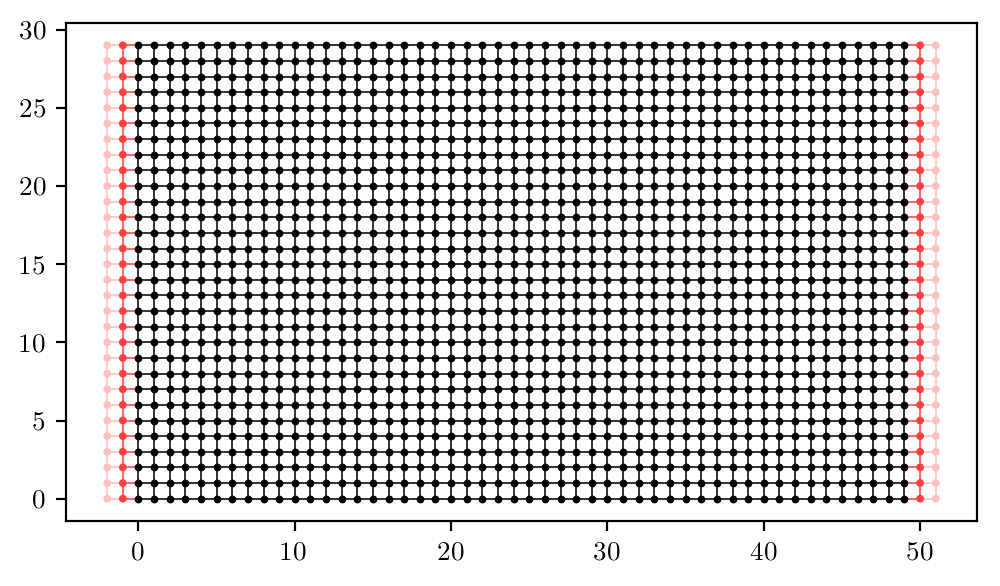

In [68]:
a=1
lat = kwant.lattice.square(a=a)
t = -2
W = 30
L = 50

def onsite(site, params):
  return np.random.uniform(params.W0, -params.W0)

def hopping(site_i, site_j, params):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return params.t*np.exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
  
sys = kwant.Builder()
sys[(lat(x, y) for x in range(L) for y in range(W))] = onsite
sys[lat.neighbors()] = hopping

lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
lead[(lat(0, y) for y in range(W))] = -4*t   # no disorder in lead!
lead[lat.neighbors()] = hopping

sys.attach_lead(lead)
sys.attach_lead(lead.reversed())
fig=kwant.plot(sys, dpi=196);
fig.savefig("square_lattice_W={0}_L={1}".format(W, L), dpi=196)

In [91]:
Gs = {}
phi = 0.0

np.random.seed(0)
W0s = np.linspace(0, 10, 20) #np.logspace(0, np.log(5000)/np.log(10), 50)
energies = np.linspace(0, 0.6, 4)

fsyst = sys.finalized()
for e in energies:
  Gs[repr(e)] = []
  for W0 in W0s:
      params = SimpleNamespace(phi=phi, W0=W0, t=t)
      smat = kwant.smatrix(fsyst, energy=energy, args=[params])
      Gs[repr(e)].append(smat.transmission(1, 0))

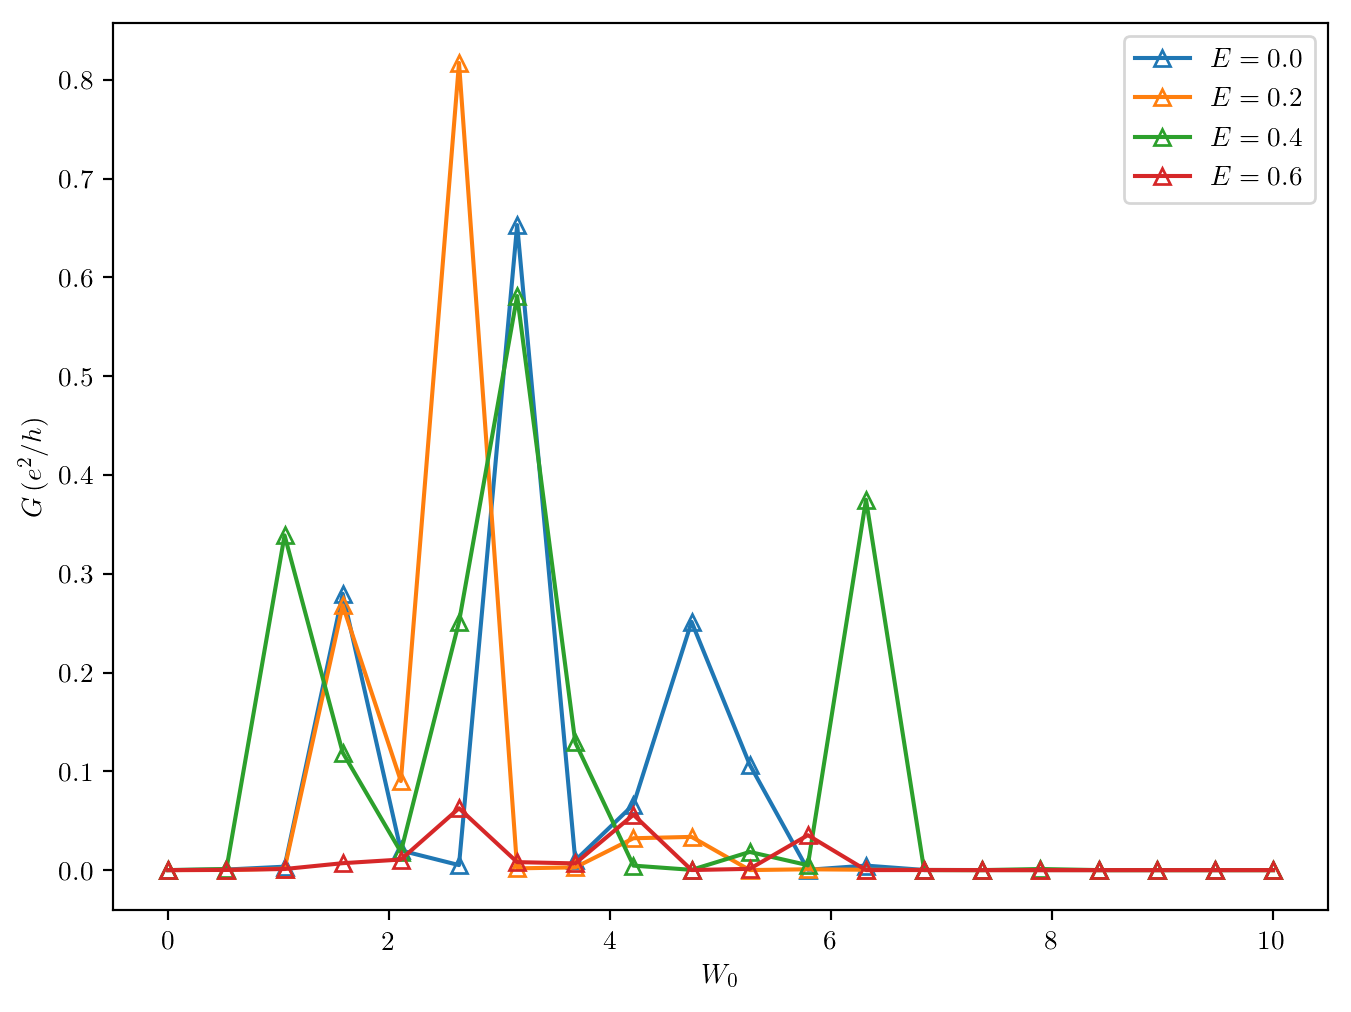

In [92]:
plt.figure(figsize=(8,6), dpi=196)
for e in energies:
  plt.plot(W0s, Gs[repr(e)], '^-', mfc='none', label="$E={}$".format(np.round(e, 2)));
#plt.xscale('log')
plt.ylabel("$G\,(e^2/h)$")
plt.xlabel("$W_0$")
plt.legend()
plt.savefig("transmission_square_lat_phi={}".format("dot".join(str(phi).split('.'))))

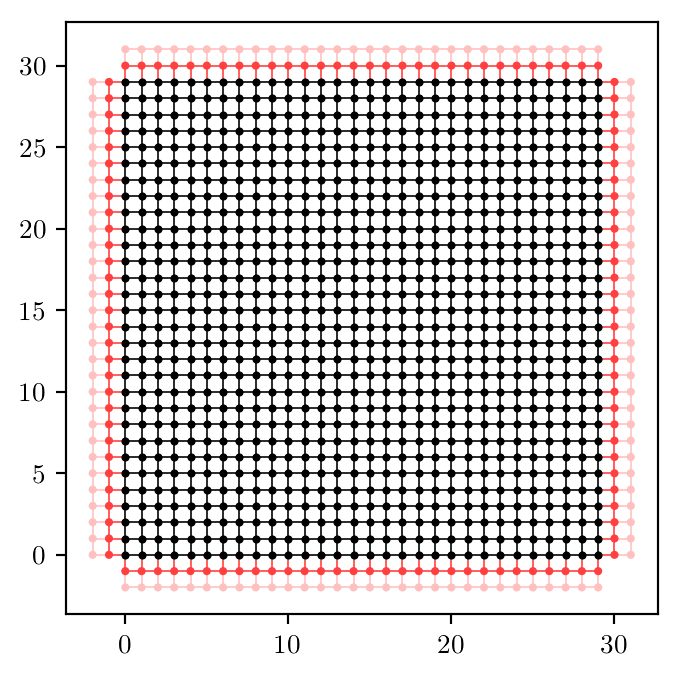

In [133]:
a=1
lat = kwant.lattice.square(a=a)
t = -2
W = 30
L = 30

def onsite(site, params):
  return np.random.uniform(params.W0, -params.W0)

def hopping(site_i, site_j, params):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return params.t*np.exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
  
sys = kwant.Builder()
sys[(lat(x, y) for x in range(L) for y in range(W))] = onsite
sys[lat.neighbors()] = hopping

lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
lead[(lat(0, y) for y in range(W))] = -4*t   # no disorder in lead!
lead[lat.neighbors()] = hopping

sys.attach_lead(lead)
sys.attach_lead(lead.reversed())

lead2 = kwant.Builder(kwant.TranslationalSymmetry([0, -a]))
lead2[(lat(x, 0) for x in range(L))] = -4*t   # no disorder in lead!
lead2[lat.neighbors()] = hopping

sys.attach_lead(lead2)
sys.attach_lead(lead2.reversed())

fig=kwant.plot(sys, dpi=196);
fig.savefig("square_lattice_4leads_W={0}_L={1}".format(W, L), dpi=196)

In [59]:
wraparound.test()

In [83]:
[np.round(e, 4) for e in np.linspace(0, 0.6000000000000001, 4)]

[0.0, 0.2, 0.4, 0.6]

In [105]:
np.random.uniform(0,0)

0.0

In [136]:
[(a,b) for a,b in zip([1,2], [2,0])]

[(1, 2), (2, 0)]